## Семинар 2 "Распознавание рукописных цифр"

ФИО: Филимонов Степан Владиславович

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
!pip install torch torchvision scikit-image

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import platform
import sys

from platform import python_version

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import torch

from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output

import time
from tqdm import tqdm
import progressbar

import warnings

from PIL import Image
  
warnings.filterwarnings('ignore') 
%matplotlib inline

In [9]:
print(f'Версия Python {platform.python_version()}')
print(f'Моя платформа {platform.platform()}')
print(f'Версия библиотеки PyTorch {torch.__version__}')
print(f'Могули я использовать CUDA? {torch.cuda.is_available()}')

Версия Python 3.11.9
Моя платформа macOS-14.6.1-arm64-arm-64bit
Версия библиотеки PyTorch 2.4.1
Могули я использовать CUDA? False


In [10]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

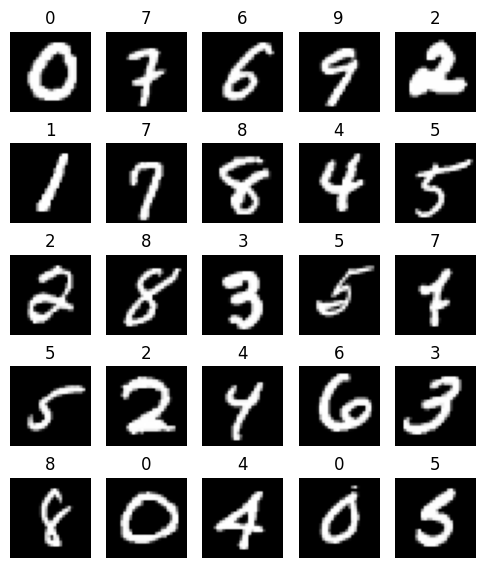

In [12]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

*Я изменил значение learning rate, при 0.01 различия сходимости практически не заметны у ReLU, ELU и Tanh*

In [13]:
LEARNING_RATE = 0.01
EPOCH = 10

In [14]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [15]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 9... (Train/Test) NLL: 0.787/0.690	Accuracy: 0.791/0.820

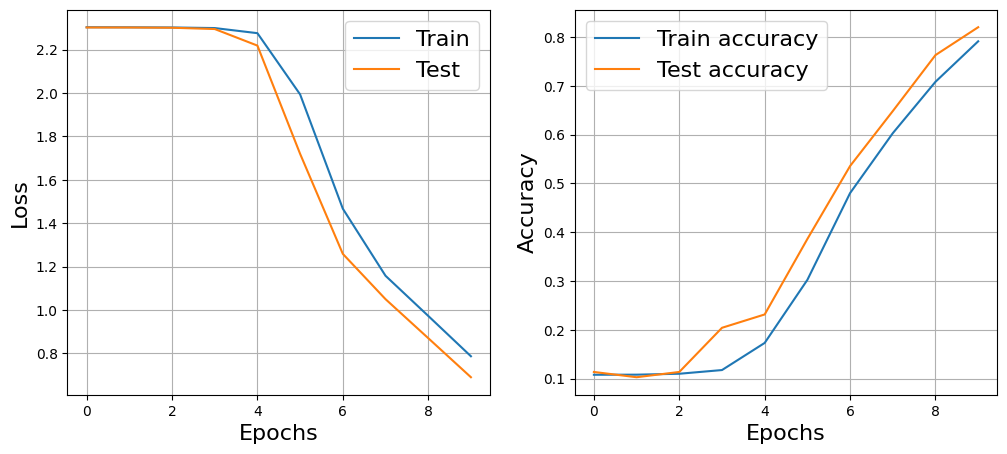

In [16]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, EPOCH, LEARNING_RATE)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [17]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [18]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 9... (Train/Test) NLL: 0.087/0.104	Accuracy: 0.975/0.967

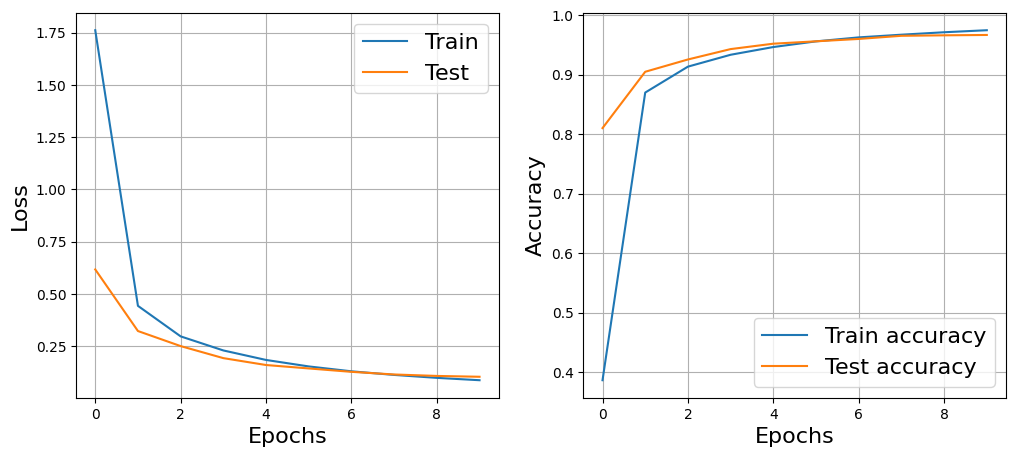

In [19]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, EPOCH, LEARNING_RATE)

Epoch 9... (Train/Test) NLL: 0.103/0.112	Accuracy: 0.970/0.966

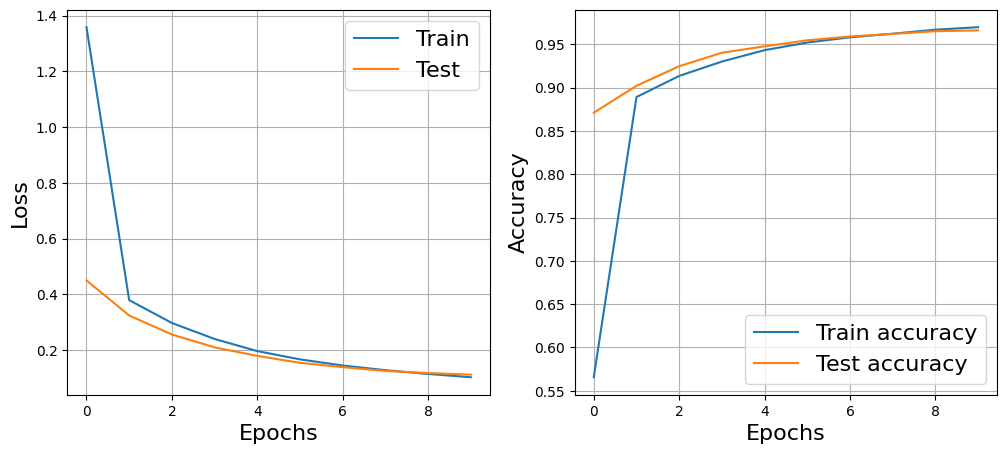

In [20]:
network = NeuralNetwork([
    Linear(784, 100), ELU(),
    Linear(100, 100), ELU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, EPOCH, LEARNING_RATE)

In [21]:
ts = {
    'Sigmoid': ts_s, 
    'ReLU': ts_r,
    'ELU': ts_e
}

In [22]:
ts_ac = {
    'Sigmoid': ts_ac_s, 
    'ReLU': ts_ac_r,
    'ELU': ts_ac_e
}

In [23]:
def PlotAll(ts: dict, ts_ac: dict):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    for key in ts:
        plt.plot(ts[key], label=key)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    for key in ts_ac:
        plt.plot(ts_ac[key], label=key)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid()
    plt.show()

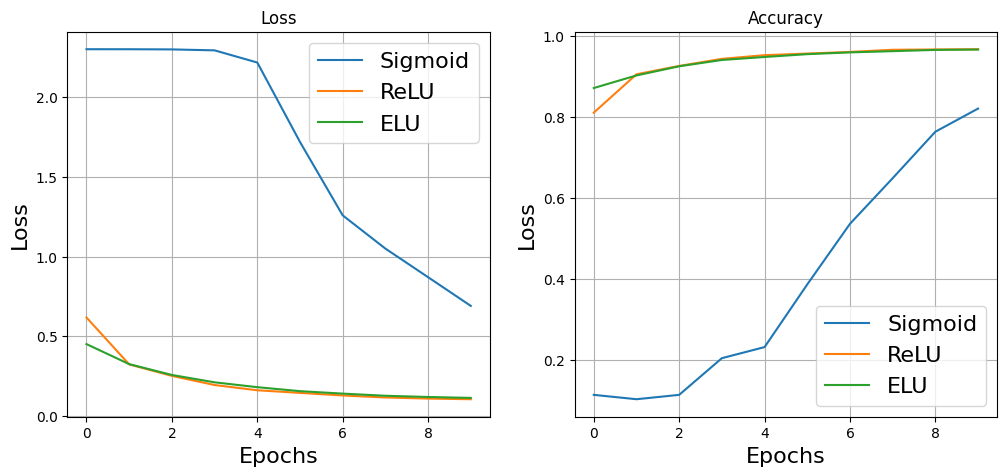

In [24]:
PlotAll(ts, ts_ac)

### HW1 (1 балл): Реализовать Tanh

In [25]:
class Tanh():
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Tanh(x) = (e^(2x) - 1) / (e^(2x) + 1)
        '''
        self.X = np.tanh(X)
        return self.X

    def backward(self, dLdy):
        return dLdy * (1 - self.X * self.X)

    def step(self, learning_rate):
        pass

Epoch 9... (Train/Test) NLL: 0.082/0.099	Accuracy: 0.978/0.969

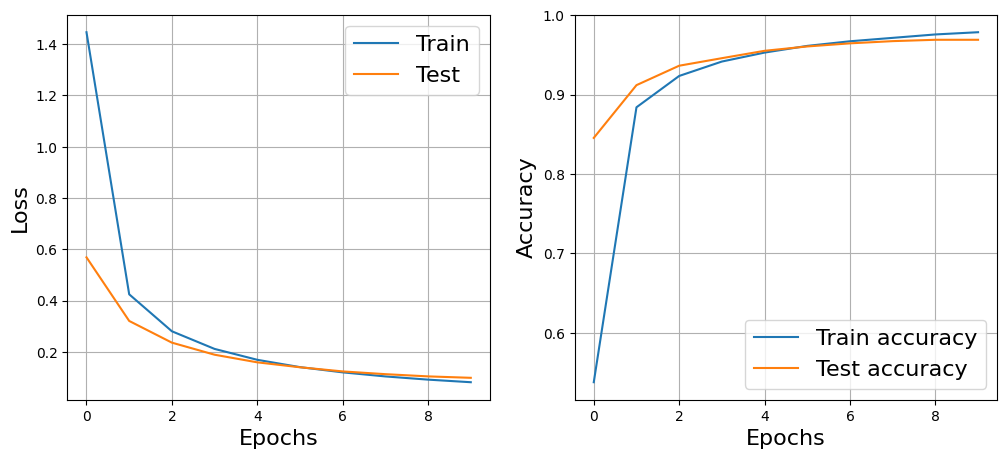

In [26]:
network = NeuralNetwork([
    Linear(784, 100), Tanh(),
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_tan, ts_tan, tr_ac_tan, ts_ac_tan = train(network, EPOCH, LEARNING_RATE)

In [27]:
ts['Tanh'] = ts_tan
ts_ac['Tanh'] = ts_ac_tan

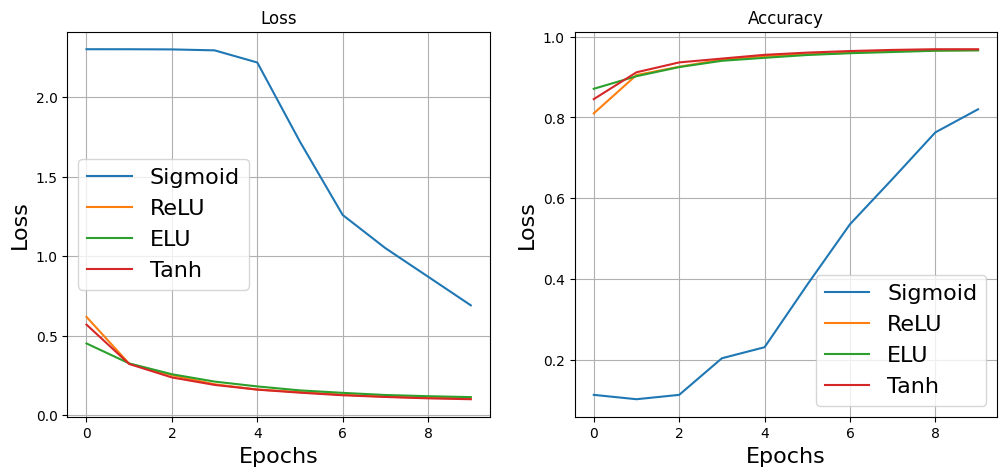

In [28]:
PlotAll(ts, ts_ac)

**Вывод:**
1) Sigmoid показывает наихудшее схождение из все.
2) ELU, ReLU и Tanh примерно одинаковые, скорее всего вызвано это входными данными и *learning_rate=0.01*, при увеличении *learning_rate* сохждение будет увеличиватся. ELU, ReLU должны будут примерно одинаковый результат показывать, Tanh должна быть чуть хуже

### Часть 3: Анализ ошибок

In [29]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

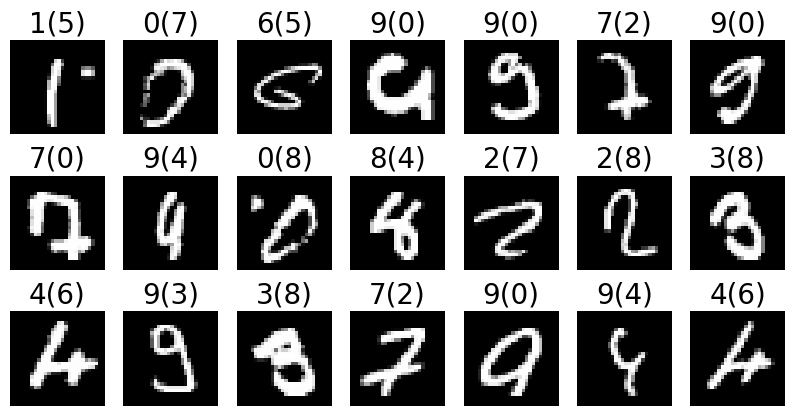

In [30]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

**Вывод:** Ошибки можно разделить на две группы, близкие и далекие.
* Близкие - например 9(0), 3(8), 2(7), 2(8) - похожие цифры, результат смазывается, *будто-то плохим подчерком*, ожидаемо, что на таких будет ошибка
* Далекие - например 6(5), 9(0) - четко можно проследить цифру, ошибка модели

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [31]:
from skimage.transform import rotate

In [32]:
def trainForTransform(network, epochs, learning_rate, train_df, test_df, name):
    loss = NLLLoss()
    test_loss_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in tqdm(range(epochs)):
            for X, y in train_df:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss.forward(prediction, y)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
            losses = []
            accuracies = []    
            for X, y in test_df:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            #print(f'{name}) Epoch {epoch}... (Test) NLL: {test_loss_epochs[-1]:.3f}\tAccuracy: {test_accuracy_epochs[-1]:.3f}')
    except KeyboardInterrupt:
        pass
    return test_loss_epochs, test_accuracy_epochs

In [33]:
def transformTrain(_transform, name):
    train_df = MNIST('.', train=True, download=True, transform=_transform)
    test_df = MNIST('.', train=False, transform=_transform)

    train_df = DataLoader(train_df, batch_size=32, shuffle=True)
    test_df = DataLoader(test_df, batch_size=32, shuffle=False)

    network = NeuralNetwork([
        Linear(784, 100), ReLU(),
        Linear(100, 100), ReLU(),
        Linear(100, 10)
    ])

    return trainForTransform(network, EPOCH, LEARNING_RATE, train_df, test_df, name)

In [34]:
ts_transform = {}
ts_ac_transform = {}

#### Поворот

In [35]:
transform_rotation = transforms.Compose([
                        transforms.RandomRotation(15),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])
ts_transform['Rotation'], ts_ac_transform['Rotation'] = transformTrain(transform_rotation, 'Rotation')

100%|███████████████████████████████████████████| 10/10 [01:25<00:00,  8.50s/it]


#### Аффинные преобразоания

In [36]:
transform_affine = transforms.Compose([
                        transforms.RandomAffine(degrees=0, translate=(0.05,0.05)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])
ts_transform['Affine'], ts_ac_transform['Affine'] = transformTrain(transform_affine, 'Affine')

100%|███████████████████████████████████████████| 10/10 [01:42<00:00, 10.24s/it]


#### Шум

In [37]:
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0):
        self._mean = mean
        self._std = std

    def __call__(self, img):
        img_array = np.array(img)
        noise = np.random.normal(self._mean, self._std, img_array.shape)
        noisy_img_array = np.clip((img_array + noise), 0, 255).astype(np.uint8)
        return Image.fromarray(noisy_img_array)

In [38]:
transform_noise = transforms.Compose([
                        AddGaussianNoise(0, 25),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])
ts_transform['Noise'], ts_ac_transform['Noise'] = transformTrain(transform_noise, 'Noise')

100%|███████████████████████████████████████████| 10/10 [01:46<00:00, 10.64s/it]


#### Все наложения

In [39]:
transform_all = transforms.Compose([
                        transforms.RandomAffine(degrees=15, translate=(0.05,0.05)),
                        AddGaussianNoise(0, 25),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])
ts_transform['All'], ts_ac_transform['All'] = transformTrain(transform_all, 'All')

100%|███████████████████████████████████████████| 10/10 [02:01<00:00, 12.16s/it]


#### Ничего

In [40]:
transform_norm = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])
ts_transform['Norm'], ts_ac_transform['Norm'] = transformTrain(transform_norm, 'Norm')

100%|███████████████████████████████████████████| 10/10 [01:10<00:00,  7.09s/it]


#### График

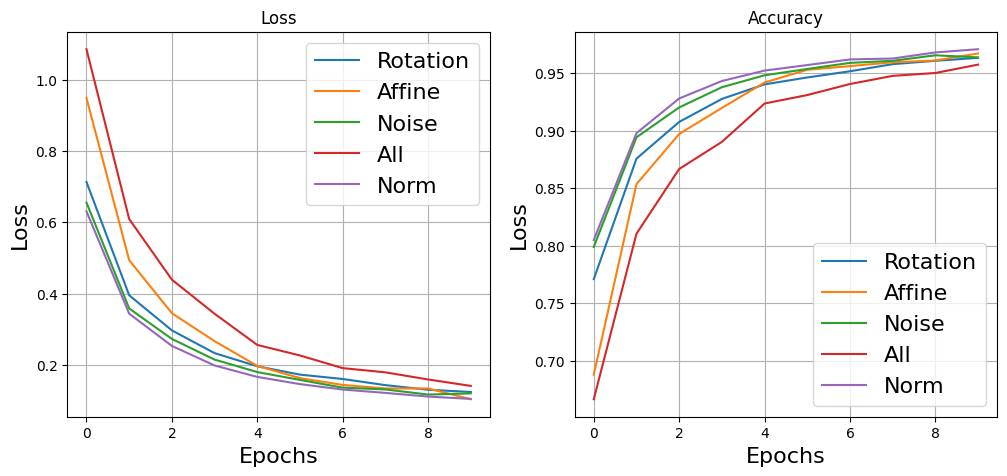

In [41]:
PlotAll(ts_transform, ts_ac_transform)

**Вывод:** Чем больше ''шумов'' наложенно на данные, тем дольше происходить схождение

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

**Вывод:**
1) Sigmoid показывает наихудшее схождение из все. ELU, ReLU и Tanh примерно одинаковые, скорее всего вызвано это входными данными и *learning_rate=0.01*, при увеличении *learning_rate* сохждение будет увеличиватся. ELU, ReLU должны будут примерно одинаковый результат показывать, Tanh должна быть чуть хуже

2) Шумы наложенные на данные увеличивают качество обучения, но и вместе с тем увеливается время схождения.

P.s. В целом так или иначе проведенный эксперимент больше является сильно приблеженным, на малой выборке. В идеале надо проводить более объемный тест, на большой выборке, и с больше колличеством проверяемых параметров, например есть [другие](https://habr.com/ru/articles/727506/) функции активации, которые можно было бы так же проверить, так же возможно увеличить тренеровачную и тестовую выборку.